In [1]:
import json
import os
from pathlib import Path
import time
import copy
import datetime

import numpy as np
import pandas as pd
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models
from fastai.dataset import open_image
import json
from PIL import ImageDraw, ImageFont
import matplotlib.pyplot as plt
from matplotlib import patches, patheffects
import cv2
from tqdm import tqdm

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
# params
SIZE = 224
EPOCHS = 5
BATCH_SIZE = 32
NUM_WORKERS = 4
SHOW_IMAGES = False

# static
IMAGES = 'images'
ANNOTATIONS = 'annotations'
CATEGORIES = 'categories'
ID = 'id'
NAME = 'name'
IMAGE_ID = 'image_id'
BBOX = 'bbox'
CATEGORY_ID = 'category_id'
FILE_NAME = 'file_name'
IMAGE = 'image'
CATEGORY = 'category'
TRAIN = 'train'
VAL = 'val'
TEST = 'test'

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = 'cpu'
print('device:', device)

device: cuda:0


Adjust data dir path for Paperspace or Kaggle

In [4]:
home_dir = os.path.expanduser('~')

if home_dir == '/home/paperspace':
    DATA_DIR = '/home/paperspace/data/pascal'
else: # kaggle
    DATA_DIR = '../input/pascal/pascal'

In [5]:
PATH = Path(DATA_DIR)
list(PATH.iterdir())

[PosixPath('/home/paperspace/data/pascal/VOCdevkit'),
 PosixPath('/home/paperspace/data/pascal/ImageSets'),
 PosixPath('/home/paperspace/data/pascal/pascal_train2007.json'),
 PosixPath('/home/paperspace/data/pascal/SegmentationObject'),
 PosixPath('/home/paperspace/data/pascal/pascal_test2007.json'),
 PosixPath('/home/paperspace/data/pascal/pascal_val2012.json'),
 PosixPath('/home/paperspace/data/pascal/SegmentationClass'),
 PosixPath('/home/paperspace/data/pascal/Annotations'),
 PosixPath('/home/paperspace/data/pascal/pascal_val2007.json'),
 PosixPath('/home/paperspace/data/pascal/pascal_train2012.json'),
 PosixPath('/home/paperspace/data/pascal/models'),
 PosixPath('/home/paperspace/data/pascal/JPEGImages'),
 PosixPath('/home/paperspace/data/pascal/tmp')]

In [6]:
train_data = json.load((PATH/'pascal_train2007.json').open())
val_data = json.load((PATH/'pascal_val2007.json').open())
test_data = json.load((PATH/'pascal_test2007.json').open())

print('train:', train_data.keys())
print('val:', val_data.keys())
print('test:', test_data.keys())

train: dict_keys(['images', 'type', 'annotations', 'categories'])
val: dict_keys(['images', 'type', 'annotations', 'categories'])
test: dict_keys(['images', 'type', 'annotations', 'categories'])


In [7]:
def preview_data(data):
    if isinstance(data, (list, tuple)):
        return data[0]
    elif isinstance(data, dict):
        return next(iter(data.items()))
    else:
        raise TypeError(f"Unsupported type: {type(data)}")

In [8]:
preview_data(train_data[ANNOTATIONS])

{'segmentation': [[155, 96, 155, 270, 351, 270, 351, 96]],
 'area': 34104,
 'iscrowd': 0,
 'image_id': 12,
 'bbox': [155, 96, 196, 174],
 'category_id': 7,
 'id': 1,
 'ignore': 0}

In [9]:
preview_data(train_data[IMAGES])

{'file_name': '000012.jpg', 'height': 333, 'width': 500, 'id': 12}

In [10]:
categories = train_data[CATEGORIES]

NUM_CATEGORIES = len(categories)
print('category count:', NUM_CATEGORIES)

category count: 20


In [11]:
# all categories are the same
train_categories = {c[ID]:c[NAME] for c in train_data[CATEGORIES]}
val_categories = {c[ID]:c[NAME] for c in val_data[CATEGORIES]}
test_categories = {c[ID]:c[NAME] for c in test_data[CATEGORIES]}
assert train_categories == val_categories == test_categories

categories = train_categories
print(categories)

{1: 'aeroplane', 2: 'bicycle', 3: 'bird', 4: 'boat', 5: 'bottle', 6: 'bus', 7: 'car', 8: 'cat', 9: 'chair', 10: 'cow', 11: 'diningtable', 12: 'dog', 13: 'horse', 14: 'motorbike', 15: 'person', 16: 'pottedplant', 17: 'sheep', 18: 'sofa', 19: 'train', 20: 'tvmonitor'}


In [12]:
IMAGE_PATH = Path(PATH/'JPEGImages/')
list(IMAGE_PATH.iterdir())[:2]

[PosixPath('/home/paperspace/data/pascal/JPEGImages/006948.jpg'),
 PosixPath('/home/paperspace/data/pascal/JPEGImages/005796.jpg')]

Helper functions for setting up `pandas.DataFrame` fed to the torch `Dataset`

In [13]:
def get_filenames(data):
    filenames = {o[ID]:o[FILE_NAME] for o in data[IMAGES]}
    print('get_id_filename_dict')
    print('length:', len(filenames), 'next item:', next(iter(filenames.items())))
    return filenames

In [14]:
def get_image_ids(data):
    image_ids = [o[ID] for o in data[IMAGES]]
    print('get_image_ids')
    print('length:', len(image_ids), 'next item:', image_ids[0])
    return image_ids

In [15]:
def pascal_bb_hw(bb):
    return bb[2:]

bbox = train_data[ANNOTATIONS][0][BBOX]
pascal_bb_hw(bbox)

[196, 174]

In [16]:
def get_image_w_area(data, image_ids):
    image_w_area = {i:None for i in image_ids}
    image_w_area = copy.deepcopy(image_w_area)
    for x in data[ANNOTATIONS]:
        bbox = x[BBOX]
        new_category_id = x[CATEGORY_ID]
        image_id = x[IMAGE_ID]
        h, w = pascal_bb_hw(bbox)
        new_area = h*w
        cat_id_area = image_w_area[image_id]
        if not cat_id_area:
            image_w_area[image_id] = (new_category_id, new_area)
        else:
            category_id, area = cat_id_area
            if new_area > area:
                image_w_area[image_id] = (new_category_id, new_area)
    print('get_image_w_area')
    print('length:', len(image_w_area), 'next item:', next(iter(image_w_area.items())))
    return image_w_area

train data structs

In [17]:
train_filenames = get_filenames(train_data)
train_image_ids = get_image_ids(train_data)
train_image_w_area = get_image_w_area(train_data, train_image_ids)

get_id_filename_dict
length: 2501 next item: (12, '000012.jpg')
get_image_ids
length: 2501 next item: 12
get_image_w_area
length: 2501 next item: (12, (7, 34104))


### check that the largest bbox is being correctly calculated

In [18]:
type(train_image_w_area)

dict

In [19]:
image_id = 6822
cat, area = train_image_w_area[image_id]
cat, area

(14, 131052)

In [20]:
categories[cat]

'motorbike'

In [21]:
for x in train_data[ANNOTATIONS]:
    if x[IMAGE_ID] == image_id:
        print(x)

{'segmentation': [[66, 7, 66, 496, 334, 496, 334, 7]], 'area': 131052, 'iscrowd': 0, 'image_id': 6822, 'bbox': [66, 7, 268, 489], 'category_id': 14, 'id': 5249, 'ignore': 0}
{'segmentation': [[295, 156, 295, 221, 333, 221, 333, 156]], 'area': 2470, 'iscrowd': 0, 'image_id': 6822, 'bbox': [295, 156, 38, 65], 'category_id': 7, 'id': 5250, 'ignore': 1}


## Image helper functions

In [22]:
def show_img(im, figsize=None, ax=None):
    if not ax:
        fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    return ax

def draw_rect(ax, b):
    patch = ax.add_patch(patches.Rectangle(b[:2], *b[-2:], fill=False, edgecolor='white', lw=2))
    draw_outline(patch, 4)
    
def draw_outline(o, lw):
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])
    
def draw_text(ax, xy, txt, sz=14):
    text = ax.text(*xy, txt,
        verticalalignment='top', color='white', fontsize=sz, weight='bold')
    draw_outline(text, 1)

## Locate the largest object's bbox

In [23]:
preview_data(train_data[ANNOTATIONS])

{'segmentation': [[155, 96, 155, 270, 351, 270, 351, 96]],
 'area': 34104,
 'iscrowd': 0,
 'image_id': 12,
 'bbox': [155, 96, 196, 174],
 'category_id': 7,
 'id': 1,
 'ignore': 0}

In [24]:
def get_image_w_bbox(data, image_ids):
    image_w_bbox = {i:None for i in image_ids}
    for x in data[ANNOTATIONS]:
        new_bbox = x[BBOX]
        new_category_id = x[CATEGORY_ID]
        image_id = x[IMAGE_ID]
        new_area = x['area']
        existing = image_w_bbox[image_id]
        if not existing:
            image_w_bbox[image_id] = (new_area, new_bbox, new_category_id)
        else:
            area, *_ = existing
            if new_area > area:
                image_w_bbox[image_id] = (new_area, new_bbox, new_category_id)
    return image_w_bbox

image_w_bbox = get_image_w_bbox(train_data, train_image_ids)

In [25]:
area, bbox, cat = image_w_bbox[image_id]
area, bbox, cat

(131052, [66, 7, 268, 489], 14)

In [26]:
train_filenames[6822]

'006822.jpg'

(500, 400, 3)
[66, 7, 268, 489]


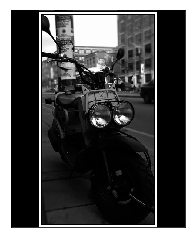

In [27]:
im = open_image(IMAGE_PATH/train_filenames[image_id])
print(im.shape)
print(bbox)
ax = show_img(im)
draw_rect(ax, bbox)

In [28]:
bbox_and_labels = []
for x in train_data[ANNOTATIONS]:
    if x[IMAGE_ID] == image_id:
        print(x)
        bbox_and_labels.append(
            [x[BBOX], x[CATEGORY_ID]]
        )
bbox_and_labels

{'segmentation': [[66, 7, 66, 496, 334, 496, 334, 7]], 'area': 131052, 'iscrowd': 0, 'image_id': 6822, 'bbox': [66, 7, 268, 489], 'category_id': 14, 'id': 5249, 'ignore': 0}
{'segmentation': [[295, 156, 295, 221, 333, 221, 333, 156]], 'area': 2470, 'iscrowd': 0, 'image_id': 6822, 'bbox': [295, 156, 38, 65], 'category_id': 7, 'id': 5250, 'ignore': 1}


[[[66, 7, 268, 489], 14], [[295, 156, 38, 65], 7]]

(500, 400, 3)
[66, 7, 268, 489]


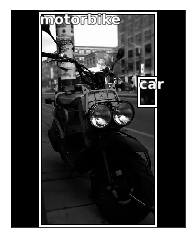

In [29]:
im = open_image(IMAGE_PATH/train_filenames[image_id])
print(im.shape)
print(bbox)
ax = show_img(im)
for bbox, cat in bbox_and_labels:
    draw_rect(ax, bbox)
    draw_text(ax, bbox[:2], categories[cat])

show image with bbox - using the above image functions

[155, 96, 196, 174]


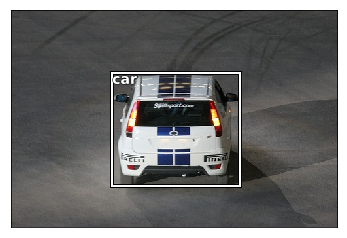

In [30]:
image_id, (area, bbox, cat) = next(iter(image_w_bbox.items()))
fn = f'{IMAGE_PATH}/{train_filenames[image_id]}'
im = open_image(fn)
ax = show_img(im)
b = bbox
print(b)
draw_rect(ax, b)
draw_text(ax, b[:2], categories[cat])

In [31]:
def scale_pascal_bb(bbox, image, size):
    """
    Returns a bbox scaled to the target `size`
    
    Args:
        bbox (1d array): pascal_bb [x, y, x2, y2]
        image (3d array): HWC
        size (scalar): target image size that bbox should be scaled to
    """
    im_w = image.shape[1]
    im_h = image.shape[0]
    return np.multiply(np.divide(bbox, [im_w, im_h, im_w, im_h]), size)

[ 69.44     64.57658  87.808   117.04505]


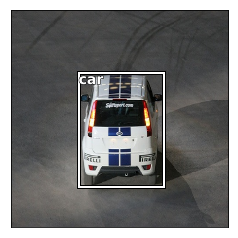

In [32]:
image_id, (area, bbox, cat) = next(iter(image_w_bbox.items()))
fn = f'{IMAGE_PATH}/{train_filenames[image_id]}'
im = open_image(fn)
resized_image = cv2.resize(im, (SIZE, SIZE)) # HW
ax = show_img(resized_image)
size=224
b = scale_pascal_bb(bbox, im, size)
print(b)
draw_rect(ax, b)
draw_text(ax, b[:2], categories[cat])

# Dataset

Scales image to (3, 224, 224) for Resnet18

Also scales the bbox

In [33]:
next(iter(train_filenames.items()))

(12, '000012.jpg')

In [34]:
def get_full_filenames(id_filename_dict):
    """
    Returns a list of 2 item tuples (image_id, image_full_path)
    
    Args:
        id_filename_dict (dict): {image_id: filename}
    """
    return [
         (k, f'{IMAGE_PATH}/{v}')
      for k,v in id_filename_dict.items()]

train_full_filenames = get_full_filenames(train_filenames)

In [35]:
tff = next(iter(train_full_filenames))
tff

(12, '/home/paperspace/data/pascal/JPEGImages/000012.jpg')

In [36]:
open_image(tff[1]).shape

(333, 500, 3)

In [37]:
class BboxDataset(Dataset):
    def __init__(self, full_filenames, data_bbox):
        """
        Args:
            full_filenames (list): [(image_id, image_full_path), ...]
            data_bbox (dict): {image_id: (area, bbox, cat), ...}
        """
        self.full_filenames = full_filenames
        self.data_bbox = data_bbox

    def __len__(self):
        return len(self.full_filenames)
    
    def __getitem__(self, idx):
        image_id, image_path = self.full_filenames[idx]
        im = open_image(image_path) # HW
        resized_image = cv2.resize(im, (SIZE, SIZE)) # HW
        image = np.transpose(resized_image, (2, 0, 1)) # CHW
        
        _, bbox, cat = self.data_bbox[image_id]
        scaled_bbox = scale_pascal_bb(bbox, im, SIZE)

        return image_id, image, (scaled_bbox, cat)
    
dataset = BboxDataset(train_full_filenames, image_w_bbox)
idx = 0
image_id, inputs, label = dataset[0]

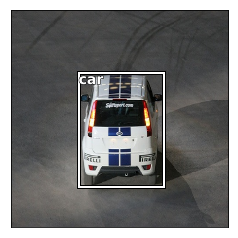

In [38]:
def show_image_and_bbox(inputs, label):
    """
    Args:
        inputs (3d ndarray): CHW
        label (list): [bbox, category_id]
    """
    ax = show_img(np.transpose(inputs, (1, 2, 0)))
    (bbox, cat) = label
    draw_rect(ax, bbox)
    draw_text(ax, bbox[:2], categories[cat])
        
show_image_and_bbox(inputs, label)

### Val Dataset

val data structs

In [39]:
val_filenames = get_filenames(val_data)
val_image_ids = get_image_ids(val_data)
val_image_w_area = get_image_w_area(val_data, val_image_ids)

get_id_filename_dict
length: 2510 next item: (5, '000005.jpg')
get_image_ids
length: 2510 next item: 5
get_image_w_area
length: 2510 next item: (5, (9, 9701))


In [40]:
val_full_filenames = get_full_filenames(val_filenames)
next(iter(val_full_filenames))

(5, '/home/paperspace/data/pascal/JPEGImages/000005.jpg')

In [41]:
val_image_w_bbox = get_image_w_bbox(val_data, val_image_ids)

In [42]:
val_dataset = BboxDataset(val_full_filenames, val_image_w_bbox)

In [43]:
preview_data(val_filenames)

(5, '000005.jpg')

In [44]:
val_data[ANNOTATIONS][0]

{'segmentation': [[262, 210, 262, 339, 324, 339, 324, 210]],
 'area': 7998,
 'iscrowd': 0,
 'image_id': 5,
 'bbox': [262, 210, 62, 129],
 'category_id': 9,
 'id': 1,
 'ignore': 0}

In [45]:
val_image_w_bbox = get_image_w_bbox(val_data, val_image_ids)
preview_data(val_image_w_bbox)

(5, (9701, [164, 263, 89, 109], 9))

In [46]:
print(preview_data(val_full_filenames))
print(preview_data(val_image_w_bbox))

(5, '/home/paperspace/data/pascal/JPEGImages/000005.jpg')
(5, (9701, [164, 263, 89, 109], 9))


In [47]:
val_dataset = BboxDataset(val_full_filenames, val_image_w_bbox)
idx = 2
image_id, inputs, label = val_dataset[idx]
image_id, inputs.shape, label

(9, (3, 224, 224), (array([ 30.464, 102.144,  90.496,  94.976]), 13))

In [48]:
label

(array([ 30.464, 102.144,  90.496,  94.976]), 13)

show Validation dataset image w/ bbox

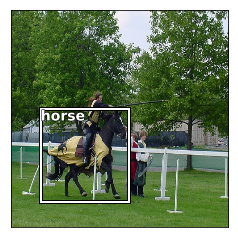

In [49]:
show_image_and_bbox(inputs, label)

Show the above image at **full scale** for the ground truth to see if it's correct

In [50]:
idx = 2
image_id, filename = val_full_filenames[idx]
image_id, filename

(9, '/home/paperspace/data/pascal/JPEGImages/000009.jpg')

In [51]:
area, bbox, cat = val_image_w_bbox[image_id]
area, bbox, cat

(32118, [68, 171, 202, 159], 13)

In [52]:
categories[cat]

'horse'

In [53]:
im = open_image(filename)
im.shape

(375, 500, 3)

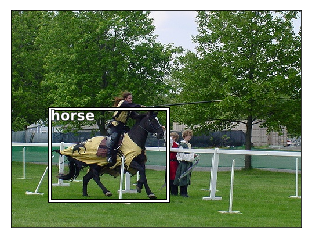

In [54]:
ax = show_img(im)
draw_rect(ax, bbox)
draw_text(ax, bbox[:2], categories[cat])

bbox helper functions

In [55]:
def fastai_bb(bb):
    return np.array([bb[1], bb[0], bb[3]+bb[1]-1, bb[2]+bb[0]-1])

print(bbox)
print(fastai_bb(bbox))

[68, 171, 202, 159]
[171  68 329 269]


In [56]:
def pascal_bb_hw(bb):
    return bb[2:]

bbox = train_data[ANNOTATIONS][0][BBOX]
pascal_bb_hw(bbox)

[196, 174]

# DataLoader

In [57]:
BATCH_SIZE = 64
NUM_WORKERS = 0

dataloader = DataLoader(dataset, batch_size=BATCH_SIZE,
                        shuffle=True, num_workers=NUM_WORKERS)

batch_image_ids, batch_inputs, batch_labels = next(iter(dataloader))

In [58]:
batch_inputs.size()

torch.Size([64, 3, 224, 224])

In [59]:
# batch_labels is a list, the first item is the "batch bbox's", 2nd item is "batch categories"

In [60]:
len(batch_labels)

2

In [61]:
batch_labels[0].size()

torch.Size([64, 4])

In [62]:
batch_labels[1].size()

torch.Size([64])

In [63]:
# train the model

Val DataLoader

In [64]:
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE,
                            shuffle=True, num_workers=NUM_WORKERS)

Device check

In [65]:
print('DEVICE:', device)

DEVICE: cuda:0


# Build model

In [66]:
model_ft = models.resnet18(pretrained=True)

for layer in model_ft.parameters():
    layer.requires_grad = False
    
num_ftrs = model_ft.fc.in_features
IN_FEATURES = num_ftrs

print(IN_FEATURES, NUM_CATEGORIES)

# model_ft.fc = nn.Linear(num_ftrs, NUM_CATEGORIES)

# model_ft = model_ft.to(device)

# criterion = nn.CrossEntropyLoss()

# # Observe that all parameters are being optimized
# optimizer = optim.SGD(model_ft.parameters(), lr=0.01, momentum=0.9)

512 20


# Custom head with single Layer fork to 2 outputs

`[bbox preds, category preds]`

In [67]:
class BboxAndCatLayer(nn.Module):
    def __init__(self):
        super().__init__()
        self.cat_layer = nn.Linear(IN_FEATURES, NUM_CATEGORIES)
        self.bbox_layer = nn.Linear(IN_FEATURES, 4)
        
    def forward(self, x):
        return (self.bbox_layer(x), self.cat_layer(x), )
    
model_ft.fc = BboxAndCatLayer()

model_ft = model_ft.to(device)

### check Model output dimen

In [68]:
image_ids, inputs, labels = next(iter(dataloader))

In [69]:
print(len(labels))
print(type(labels))
print(labels[0].size())
print(labels[0].dtype)
print(labels[1].size())
print(labels[1].dtype)

2
<class 'list'>
torch.Size([64, 4])
torch.float64
torch.Size([64])
torch.int64


In [70]:
inputs = inputs.to(device)
outputs = model_ft(inputs)

In [71]:
bbox_outputs, cat_outputs = outputs
bbox_outputs.size(), cat_outputs.size()

(torch.Size([64, 4]), torch.Size([64, 20]))

In [72]:
_, cat_preds = torch.max(cat_outputs, dim=1)
cat_preds.size()

torch.Size([64])

In [73]:
preds = [bbox_outputs, cat_outputs]

print(preds[0].size())
print(preds[0].dtype)
print(preds[1].size())
print(preds[1].dtype)

torch.Size([64, 4])
torch.float32
torch.Size([64, 20])
torch.float32


# Loss Function - for custom head

In [74]:
class BboxAndCatLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.bbox_loss = nn.L1Loss()
        self.cat_loss = nn.CrossEntropyLoss()
        
    def forward(self, preds, targets):
        bbox_preds, cat_preds = preds
        bbox_targets, cat_targets = targets

        # data munging
        bbox_preds = bbox_preds.to(device, torch.float64)
        cat_targets_0_indexed = cat_targets - 1
        
        # per type of loss
        bbox_loss = self.bbox_loss(bbox_preds, bbox_targets)
        cat_loss = self.cat_loss(cat_preds, cat_targets_0_indexed)
        # cast b/c bbox_loss.dtype == torch.float64
        cat_loss = cat_loss.to(device, dtype=torch.float64)
        
        return bbox_loss + cat_loss
    
criterion = BboxAndCatLoss()

preds = [p.to(device) for p in preds]
labels = [x.to(device) for x in labels]

loss = criterion(preds, labels)
loss

tensor(97.0959, device='cuda:0', dtype=torch.float64, grad_fn=<ThAddBackward>)

# Train the model

In [75]:
# Observe that all parameters are being optimized
optimizer = optim.SGD(model_ft.parameters(), lr=0.01, momentum=0.9)

In [76]:
TRAIN = 'train'
VAL = 'val'

dataloaders = {
    TRAIN: dataloader,
    VAL: val_dataloader
}

dataset_sizes = {
    TRAIN: len(dataset),
    VAL: len(val_dataset)
}

In [77]:
epoch_losses = {TRAIN: [], VAL: []}
epoch_accuracies = {TRAIN: [], VAL: []}

In [78]:
best_model_weights = copy.deepcopy(model_ft.state_dict())
best_acc = 0.0

In [79]:
EPOCHS = 5

for epoch in tqdm(range(EPOCHS)):
    print('epoch:', epoch)
    
    for phase in [TRAIN, VAL]:
        running_loss = 0.0
        running_correct = 0

        for image_ids, inputs, labels in dataloaders[phase]:
            inputs = inputs.to(device)

            # labels - separate to.(device) b/c labels is a list
            (bbox_labels, cat_labels) = labels
            bbox_labels = bbox_labels.to(device)
            cat_labels = cat_labels.to(device)

            # clear gradients
            optimizer.zero_grad()

            # forward pass
            outputs = model_ft(inputs)
            bbox_outputs, cat_outputs = outputs
            _, preds = torch.max(cat_outputs, dim=1)
            loss = criterion(outputs, (bbox_labels, cat_labels))

            # backwards pass
            if phase == TRAIN:
                loss.backward()
                optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            labels_0_indexed = cat_labels - 1
            running_correct += torch.sum(preds == labels_0_indexed)

        # per epoch/phase
        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_correct.double().item() / dataset_sizes[phase]
        epoch_losses[phase].append(epoch_loss)
        epoch_accuracies[phase].append(epoch_acc)

    if epoch_accuracies[VAL][-1] > best_acc:
        best_acc = epoch_accuracies[VAL][-1]
        best_model_weights = copy.deepcopy(model_ft.state_dict())
        
    print('train loss:', epoch_losses[TRAIN][-1], 'train acc:', epoch_accuracies[TRAIN][-1])
    print('val loss:', epoch_losses[VAL][-1], 'val acc:', epoch_accuracies[VAL][-1])

  0%|          | 0/5 [00:00<?, ?it/s]

epoch: 0


 20%|██        | 1/5 [00:33<02:13, 33.44s/it]

train loss: 58.15765066766532 train acc: 0.5257896841263494
val loss: 44.36299114233836 val acc: 0.6932270916334662
epoch: 1


 40%|████      | 2/5 [01:07<01:41, 33.87s/it]

train loss: 42.55651255476236 train acc: 0.748500599760096
val loss: 42.115879003729326 val acc: 0.701593625498008
epoch: 2


 60%|██████    | 3/5 [01:41<01:07, 33.67s/it]

train loss: 40.8198553908213 train acc: 0.7804878048780488
val loss: 40.958989180204824 val acc: 0.7019920318725099
epoch: 3


 80%|████████  | 4/5 [02:13<00:33, 33.44s/it]

train loss: 39.504337188926804 train acc: 0.7916833266693323
val loss: 39.81548702436047 val acc: 0.7195219123505976
epoch: 4


100%|██████████| 5/5 [02:47<00:00, 33.50s/it]

train loss: 38.400947972529806 train acc: 0.7992802878848461
val loss: 38.87202203919079 val acc: 0.7386454183266933


Graph loss and accuracy

In [80]:
epoch_losses

{'train': [58.15765066766532,
  42.55651255476236,
  40.8198553908213,
  39.504337188926804,
  38.400947972529806],
 'val': [44.36299114233836,
  42.115879003729326,
  40.958989180204824,
  39.81548702436047,
  38.87202203919079]}

In [81]:
epoch_accuracies

{'train': [0.5257896841263494,
  0.748500599760096,
  0.7804878048780488,
  0.7916833266693323,
  0.7992802878848461],
 'val': [0.6932270916334662,
  0.701593625498008,
  0.7019920318725099,
  0.7195219123505976,
  0.7386454183266933]}

### check predictions

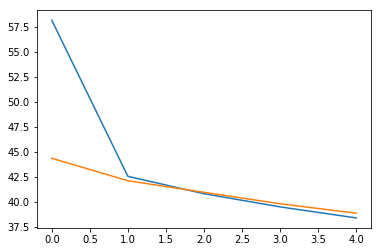

In [82]:
plt.plot(epoch_losses['train'])
plt.plot(epoch_losses['val'])

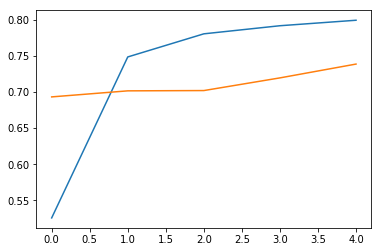

In [83]:
plt.plot(epoch_accuracies['train'])
plt.plot(epoch_accuracies['val'])

## save model weights

In [84]:
MODEL_DIR = Path.cwd()/'data/model'
print(MODEL_DIR)
print('isdir:', os.path.isdir(MODEL_DIR))

/home/paperspace/pytorch-practice/notebooks/data/model
isdir: True


In [85]:
def maybe_create_model_dir():
    if not os.path.isdir(MODEL_DIR):
        os.mkdir(MODEL_DIR)

def save(state_dict):
    filepath = f'{MODEL_DIR}/model_{datetime.datetime.now().isoformat()}.pth'
    torch.save(state_dict, filepath)
    return filepath
    
maybe_create_model_dir()

filepath = save(model_ft.state_dict())
filepath

'/home/paperspace/pytorch-practice/notebooks/data/model/model_2018-10-06T14:53:44.960237.pth'

In [86]:
def load(model, filepath):
    state_dict = torch.load(filepath)
    model.load_state_dict(state_dict)
    return model

model = load(model_ft, filepath)
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

## View predictions

In [87]:
bbox_outputs, cat_outputs = outputs
_, preds = torch.max(cat_outputs, dim=1)
preds

tensor([ 4,  2, 14, 14, 14,  2, 14,  6,  0, 11, 14,  6, 14, 15], device='cuda:0')

predicted

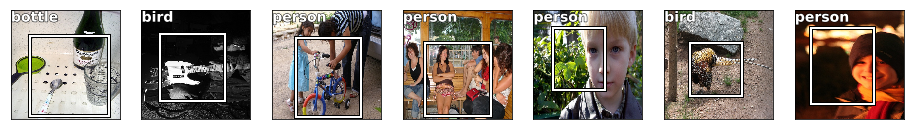

In [88]:
preds_count = len(preds)
fig, axes = plt.subplots(1, 7, figsize=(16, 16))
for i, ax in enumerate(axes.flat):
    im = np.transpose(inputs[i], (1, 2, 0))
    ax = show_img(im, ax=ax)
    draw_rect(ax, bbox_outputs[i])
    draw_text(ax, (0,0), categories[preds[i].item()+1])

Ground truth

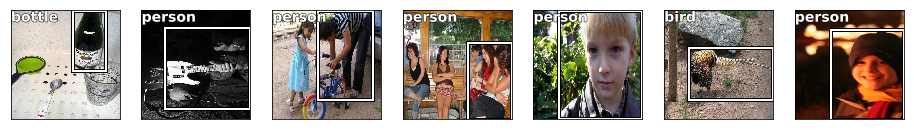

In [89]:
preds_count = len(preds)
fig, axes = plt.subplots(1, 7, figsize=(16, 16))
for i, ax in enumerate(axes.flat):
    im = np.transpose(inputs[i], (1, 2, 0))
    ax = show_img(im, ax=ax)
    draw_rect(ax, labels[0][i])
    draw_text(ax, (0,0), categories[labels[1][i].item()])